# Clase 2: Pandas y estadística descriptiva

In [45]:
import pandas as pd
import numpy as np
import matplotlib

matplotlib.style.use("ggplot")
%matplotlib inline

## Parámetros y extracción de datos

In [5]:
# input
CASOS_URL = "https://sisa.msal.gov.ar/datos/descargas/covid-19/files/Covid19Casos.csv"
DETERMINACONES_URL = "https://sisa.msal.gov.ar/datos/descargas/covid-19/files/Covid19Determinaciones.csv"
CASOS_PATH = "data/covid_casos.csv"
DETERMINACIONES_PATH = "data/covid_determinaciones.csv"

# output
PANEL_CASOS_PATH = "data/covid19-casos-panel.csv"

Si los sacamos de internet, podemos usar directamente la URL de cualquier CSV. Siempre es buena práctica guardar una copia por si en algún momento una URL deja de estar disponible.

In [12]:
#casos = pd.read_csv(CASOS_URL, encoding="utf-16le")
#determinaciones = pd.read_csv(DETERMINACONES_URL, encoding="utf-16le")

#casos.to_csv(CASOS_PATH, encoding="utf8", index=False)
#determinaciones.to_csv(DETERMINACIONES_PATH, encoding="utf8", index=False)

In [11]:
converters = {
    "residencia_provincia_id": lambda x: str(x).zfill(2),
    "departamento_provincia_id": lambda x: str(x).zfill(3)
}

casos = pd.read_csv(CASOS_PATH, converters=converters)
determinaciones = pd.read_csv(DETERMINACIONES_PATH, converters=converters)

## Pivot table

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html

La función de `DataFrame.pivot_table` permite crear una tabla dinámica (de la misma forma que se podría hacer en una planilla de cálculo como Excel) fácilmente, eligiendo qué columnas se quieren mostrar en:

* **índice (index)**: lo que se usa para abrir los datos en filas.
* **columnas (columns)**: lo que se usa para abrir los datos en columnas.
* **valores (values)**: las variables que se quieren abrir en filas y columnas.

Y se puede elegir una o más funciones de agregación para aplicar a los valores cuando son agregados.

### Contar casos a partir de un registro

**Casos**

En el dataset de **casos** nos enfrentamos a un **registro**: el dataset es una lista de casos, donde cada fila es un "caso". No tenemos columnas con variables agregadas, tenemos la materia prima sobre la cual se construyen las estadísticas o las agregaciones de cualquier tipo.

Las tablas dinámicas son una buena forma de agregar! En este caso la primera agregación obvia es _contar casos_. Tratemos de **contar la cantidad de casos de Covid por provincia**. 

In [31]:
casos.columns

Index(['id_evento_caso', 'sexo', 'edad', 'edad_años_meses',
       'residencia_pais_nombre', 'residencia_provincia_nombre',
       'residencia_departamento_nombre', 'carga_provincia_nombre',
       'fecha_inicio_sintomas', 'fecha_apertura', 'sepi_apertura',
       'fecha_internacion', 'cuidado_intensivo', 'fecha_cui_intensivo',
       'fallecido', 'fecha_fallecimiento', 'asistencia_respiratoria_mecanica',
       'carga_provincia_id', 'origen_financiamiento', 'Clasificacion',
       'clasificacion_resumen', 'residencia_provincia_id', 'fecha_diagnostico',
       'residencia_departamento_id', 'ultima_actualizacion'],
      dtype='object')

In [15]:
# busquemos las columnas que vamos a necesitar usar primero
casos.head()

,id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,...,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,Clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id,ultima_actualizacion
0,672064,M,52.0,Años,Argentina,Buenos Aires,Florencio Varela,Buenos Aires,2020-05-29,NaN,...,NaN,NO,6,Público,Caso Descartado,Descartado,06,2020-06-01,274,2020-06-15
1,717629,F,46.0,Años,Argentina,Buenos Aires,Pergamino,Buenos Aires,2020-01-29,2020-01-31,...,NaN,NO,6,Público,Caso Descartado,Descartado,06,NaN,623,2020-06-15
2,717926,F,41.0,Años,Argentina,CABA,COMUNA 12,CABA,2020-01-23,2020-01-31,...,NaN,NO,2,Público,Caso Invalidado Epidemiologicamente,Descartado,02,NaN,12,2020-06-15
3,718029,F,52.0,Años,Argentina,Buenos Aires,La Plata,Buenos Aires,2020-01-29,2020-01-31,...,NaN,NO,6,Público,Caso Invalidado Epidemiologicamente,Descartado,06,NaN,441,2020-06-15
4,718055,F,34.0,Años,Argentina,CABA,SIN ESPECIFICAR,CABA,2020-01-16,2020-01-31,...,NaN,NO,2,Privado,Caso Descartado,Descartado,02,2020-02-11,0,2020-06-15


In [28]:
casos.residencia_provincia_nombre.unique()

array(['Buenos Aires', 'CABA', 'Córdoba', 'Mendoza', 'SIN ESPECIFICAR',
       'Tierra del Fuego', 'Formosa', 'Corrientes', 'Santa Fe',
       'Entre Ríos', 'La Rioja', 'Río Negro', 'Chaco', 'San Luis',
       'San Juan', 'Santa Cruz', 'Tucumán', 'Neuquén', 'La Pampa',
       'Catamarca', 'Chubut', 'Salta', 'Santiago del Estero', 'Jujuy',
       'Misiones'], dtype=object)

In [29]:
for col in casos.columns:
    if col.startswith("fecha"):
        print(col)

fecha_inicio_sintomas
fecha_apertura
fecha_internacion
fecha_cui_intensivo
fecha_fallecimiento
fecha_diagnostico


In [30]:
casos.clasificacion_resumen.value_counts()

Descartado        169443
Confirmado         32772
Sospechoso         14667
Sin Clasificar         6
Name: clasificacion_resumen, dtype: int64

In [33]:
casos_provincias = casos[casos.clasificacion_resumen == "Confirmado"].pivot_table(
    index=["residencia_provincia_nombre"],
    values=["id_evento_caso"],
    aggfunc="count"
)
casos_provincias.sort_values("id_evento_caso", ascending=False)

,id_evento_caso
residencia_provincia_nombre,
CABA,15104
Buenos Aires,13710
Chaco,1364
Río Negro,564
Córdoba,497
Santa Fe,285
SIN ESPECIFICAR,216
Neuquén,212
Tierra del Fuego,136


Primer reflejo que siempre tenés que tener: controlar el resultado con algún parámetro conocido (en lo posible). En este caso, tratemos de ver si la suma de casos tiene sentido o no.

In [34]:
casos_provincias.id_evento_caso.sum()

32772

En Google se muestra siempre el último dato reportado a la OMS, es un buen control

https://www.google.com/search?q=casos+coronavirus+argentina&oq=casos+coronavirus&aqs=chrome.1.69i57j0l6j69i60.3332j0j7&sourceid=chrome&ie=UTF-8

**Ejercicio:** crear una tabla contando la cantidad de casos fallecidos y controlarla. Pista: tenés que agregar un filtro más a la tabla anterior, que use la columna "fecha_fallecimiento".

### Crear un panel a partir de un registro

Una estructura muy común de dataset de **panel** tiene:

* 1 o más variables (generalmente numéricas)
* 1 dimensión de apertura temporal
* 1 o más dimensiones de apertura _no temporales_

Convertir registros en paneles, es un paso lógico en el procesamiento de datos primarios hacia la construcción de productos estadísticos o analíticos. Encapsula una parte del esfuerzo que conviene hacer bien de una sola vez, y luego utilizar el panel fácilmente para la mayoría de nuestras necesidades. 

En este caso vamos a elegir cuáles son nuestras variables de interés para **construir el panel de casos de Covid**:

* provincia
* sexo
* fecha (tiene que haber una dimensión temporal)

In [47]:
casos_panel = casos[casos.clasificacion_resumen == "Confirmado"].pivot_table(
    index=[
        "residencia_provincia_id",
        "residencia_provincia_nombre",
        "sexo",
        "fecha_diagnostico"
    ],
    values=["id_evento_caso"],
    aggfunc="count"
).reset_index()
casos_panel

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha_diagnostico,id_evento_caso
0,02,CABA,F,2020-03-06,1
1,02,CABA,F,2020-03-13,1
2,02,CABA,F,2020-03-14,3
3,02,CABA,F,2020-03-15,2
4,02,CABA,F,2020-03-16,2
...,...,...,...,...,...
1585,99,SIN ESPECIFICAR,M,2020-06-12,4
1586,99,SIN ESPECIFICAR,M,2020-06-13,3
1587,99,SIN ESPECIFICAR,M,2020-06-14,4
1588,99,SIN ESPECIFICAR,NR,2020-05-30,1


Ahora realizar distintos gráficos es muy fácil! Sólo hay que hacer una tabla dinámica sobre nuestro panel eligiendo las variables.

In [48]:
casos_evolucion_genero = casos_panel.pivot_table(
    columns="sexo",
    index="fecha_diagnostico",
    values="id_evento_caso",
    aggfunc="sum"
)
casos_evolucion_genero

sexo,F,M,NR
fecha_diagnostico,,,
2020-03-03,NaN,1.0,NaN
2020-03-06,2.0,4.0,NaN
2020-03-07,NaN,1.0,NaN
2020-03-08,NaN,2.0,NaN
2020-03-09,5.0,1.0,NaN
...,...,...,...
2020-06-11,743.0,717.0,11.0
2020-06-12,719.0,825.0,7.0
2020-06-13,659.0,700.0,3.0


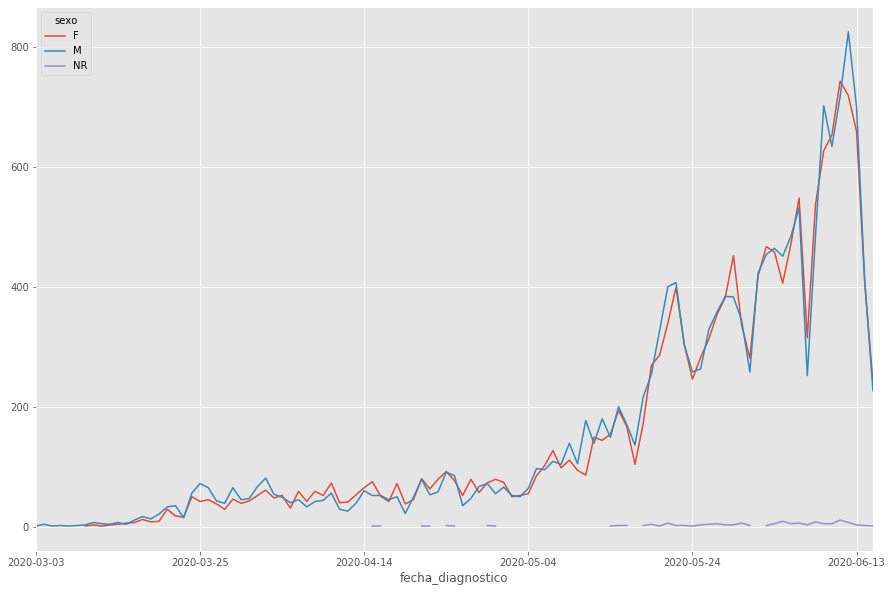

In [49]:
casos_evolucion_genero.plot(figsize=(15, 10))

**Ejercicio:** graficar la evolución de casos por provincia.

## Concat 

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html

Pero ahora queremos graficar las curvas de casos confirmados y fallecidos, y nos damos cuenta de que a nuestro panel construido para trabajar le falta una nueva dimensión de apertura de la variable **casos**: el **estado** del caso.

Tenemos que agregar la variable **estado** a nuestro panel, con por lo menos dos estados: **confirmados** y **fallecios**. Para esto vamos a construir paneles **idénticos** para cada una de las variables y concatenarlos.

In [50]:
casos_panel_confirmados = casos[casos.clasificacion_resumen == "Confirmado"].pivot_table(
    index=[
        "residencia_provincia_id",
        "residencia_provincia_nombre",
        "sexo",
        "fecha_diagnostico"
    ],
    values=["id_evento_caso"],
    aggfunc="count"
).reset_index()
casos_panel_confirmados.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha_diagnostico,id_evento_caso
0,02,CABA,F,2020-03-06,1
1,02,CABA,F,2020-03-13,1
2,02,CABA,F,2020-03-14,3
3,02,CABA,F,2020-03-15,2
4,02,CABA,F,2020-03-16,2


Ahora armemos el panel de casos fallecidos con la misma estructura.

In [53]:
casos_panel_fallecidos = casos[casos.clasificacion_resumen == "Confirmado"].pivot_table(
    index=[
        "residencia_provincia_id",
        "residencia_provincia_nombre",
        "sexo",
        "fecha_fallecimiento"
    ],
    values=["id_evento_caso"],
    aggfunc="count"
).reset_index()
casos_panel_fallecidos.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha_fallecimiento,id_evento_caso
0,02,CABA,F,2020-03-25,2
1,02,CABA,F,2020-03-28,1
2,02,CABA,F,2020-04-06,1
3,02,CABA,F,2020-04-07,1
4,02,CABA,F,2020-04-09,2


Y ahora necesitamos modificar ambos paneles para que tengan la misma estructura, y así poder concatenarlos.

* Agregar una columna para la dimensión "estado"
* Renombrar las columnas para que sigan teniendo sentido cuando sumemos información

In [51]:
casos_panel_confirmados["estado"] = "confirmados"
casos_panel_confirmados = casos_panel_confirmados.rename(columns={
    "fecha_diagnostico": "fecha",
    "id_evento_caso": "casos"
})
casos_panel_confirmados.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado
0,02,CABA,F,2020-03-06,1,confirmados
1,02,CABA,F,2020-03-13,1,confirmados
2,02,CABA,F,2020-03-14,3,confirmados
3,02,CABA,F,2020-03-15,2,confirmados
4,02,CABA,F,2020-03-16,2,confirmados


In [54]:
casos_panel_fallecidos["estado"] = "fallecidos"
casos_panel_fallecidos = casos_panel_fallecidos.rename(columns={
    "fecha_fallecimiento": "fecha",
    "id_evento_caso": "casos"
})
casos_panel_fallecidos.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado
0,02,CABA,F,2020-03-25,2,fallecidos
1,02,CABA,F,2020-03-28,1,fallecidos
2,02,CABA,F,2020-04-06,1,fallecidos
3,02,CABA,F,2020-04-07,1,fallecidos
4,02,CABA,F,2020-04-09,2,fallecidos


Y ahora el momento de la verdad! Generemos un solo panel con todos los datos.

In [56]:
casos_panel2 = pd.concat([casos_panel_confirmados, casos_panel_fallecidos])
casos_panel2

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado
0,02,CABA,F,2020-03-06,1,confirmados
1,02,CABA,F,2020-03-13,1,confirmados
2,02,CABA,F,2020-03-14,3,confirmados
3,02,CABA,F,2020-03-15,2,confirmados
4,02,CABA,F,2020-03-16,2,confirmados
...,...,...,...,...,...,...
421,90,Tucumán,F,2020-04-08,1,fallecidos
422,90,Tucumán,M,2020-03-29,1,fallecidos
423,90,Tucumán,M,2020-04-01,1,fallecidos
424,99,SIN ESPECIFICAR,M,2020-05-25,1,fallecidos


Ya podemos graficar fallecidos

In [57]:
casos_evolucion_genero2 = casos_panel2[
    casos_panel2.estado == "fallecidos"
].pivot_table(
    columns="sexo",
    index="fecha",
    values="casos",
    aggfunc="sum"
)
casos_evolucion_genero2

sexo,F,M,NR
fecha,,,
2020-03-07,NaN,1.0,NaN
2020-03-13,NaN,1.0,NaN
2020-03-18,NaN,1.0,NaN
2020-03-21,1.0,NaN,NaN
2020-03-24,NaN,3.0,NaN
...,...,...,...
2020-06-11,5.0,14.0,NaN
2020-06-12,9.0,8.0,NaN
2020-06-13,4.0,7.0,NaN


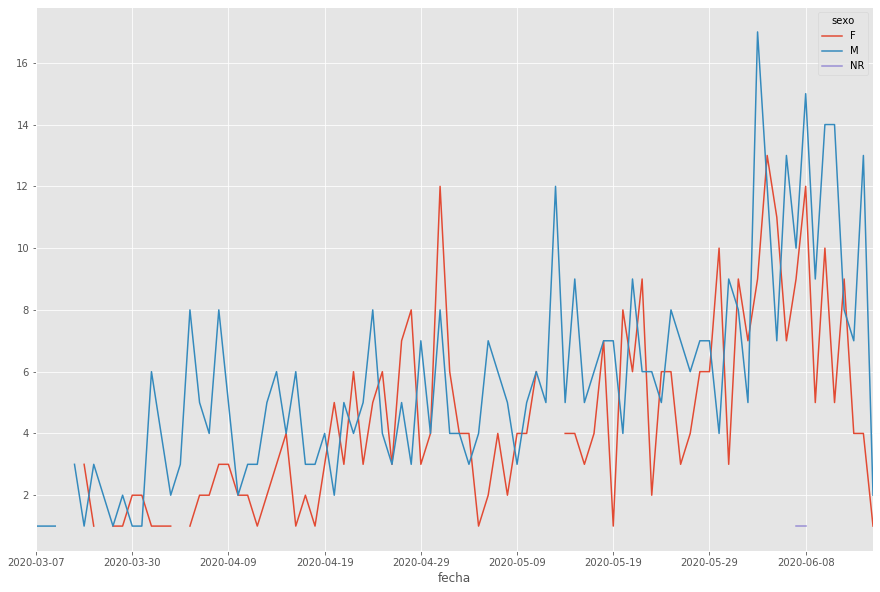

In [58]:
casos_evolucion_genero2.plot(figsize=(15,10))

## Groupby

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html

In [2]:
df.tail()

,tipo_vehiculo,anio_inscripcion_inicial,mes_inscripcion_inicial,provincia_inscripcion_inicial,letra_provincia_inscripcion_inicial,cantidad_inscripciones_iniciales,provincia_id
5803,Automotores,2020,2,Santa Cruz,Z,290,78
5804,Automotores,2020,2,Santa Fe,S,2503,82
5805,Automotores,2020,2,Santiago del Estero,G,261,86
5806,Automotores,2020,2,Tierra del Fuego,V,256,94
5807,Automotores,2020,2,Tucumán,T,792,90


In [3]:
df.groupby("anio_inscripcion_inicial").count().tail()

,tipo_vehiculo,mes_inscripcion_inicial,provincia_inscripcion_inicial,letra_provincia_inscripcion_inicial,cantidad_inscripciones_iniciales,provincia_id
anio_inscripcion_inicial,,,,,,
2016,288,288,288,288,288,288
2017,288,288,288,288,288,288
2018,288,288,288,288,288,288
2019,288,288,288,288,288,288
2020,48,48,48,48,48,48


In [4]:
df.groupby(["anio_inscripcion_inicial", "mes_inscripcion_inicial"]).count().tail()

tipo_vehiculo  \
anio_inscripcion_inicial mes_inscripcion_inicial                  
2019                     10                                  24   
                         11                                  24   
                         12                                  24   
2020                     1                                   24   
                         2                                   24   

                                                  provincia_inscripcion_inicial  \
anio_inscripcion_inicial mes_inscripcion_inicial                                  
2019                     10                                                  24   
                         11                                                  24   
                         12                                                  24   
2020                     1                                                   24   
                         2                                                   24   

                                                  letra_provincia_inscripcion_inicial  \
anio_inscripcion_inicial mes_inscripcion_inicial                                        
2019                     10                                                        24   
                         11                                                        24   
                         12                                                        24   
2020                     1                                                         24   
                         2                                                         24   

                                                  cantidad_inscripciones_iniciales  \
anio_inscripcion_inicial mes_inscripcion_inicial                                     
2019                     10                                                     24   
                         11                                                     24   
                         12                                                     24   
2020                     1                                                      24   
                         2                                                      24   

                                                  provincia_id  
anio_inscripcion_inicial mes_inscripcion_inicial                
2019                     10                                 24  
                         11                                 24  
                         12                                 24  
2020                     1                                  24  
                         2                                  24

In [5]:
df.groupby(["anio_inscripcion_inicial", "mes_inscripcion_inicial"]).sum().tail()

cantidad_inscripciones_iniciales  \
anio_inscripcion_inicial mes_inscripcion_inicial                                     
2019                     10                                                  32781   
                         11                                                  26004   
                         12                                                  21470   
2020                     1                                                   45170   
                         2                                                   27731   

                                                  provincia_id  
anio_inscripcion_inicial mes_inscripcion_inicial                
2019                     10                               1152  
                         11                               1152  
                         12                               1152  
2020                     1                                1152  
                         2                                1152

**Ejercicio:** hacer una tabla que muestre la cantidad de patentamientos por provincia que se hicieron en el 2019.

## Agg

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html

In [6]:
df_expo = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/75/distribution/75.3/download/exportaciones-mensual.csv")

In [7]:
df_expo

,indice_tiempo,ica_exportaciones_total_general,ica_exportaciones_total_productos_primarios,ica_exportaciones_animales_vivos,ica_exportaciones_pescados_mariscos,ica_exportaciones_miel,ica_exportaciones_hortalizas_legumbres_sin_elaborar,ica_exportaciones_frutas_frescas,ica_exportaciones_cereales,ica_exportaciones_semillas_frutos_oleaginosos,...,ica_maquinas_aparatos_materiales_electricos,ica_material_transporte_terrestre,ica_vehiculos_navegacion_aerea_maritima_fluvial,ica_resto_moi,ica_total_combustibles_energia,ica_petroleo_crudo,ica_carburantes_grasas_aceites_lubricantes,gas_petroleo_otros_hidrocarburos,ica_energia_electrica,ica_resto_combustibles
0,1992-01-01,725.798174,133.367679,0.505194,22.047199,3.809077,21.876559,14.239892,45.547102,19.538213,...,37.359934,16.862867,5.240765,6.726885,68.845548,29.251779,31.893742,4.144817,0.000000,3.555210
1,1992-02-01,851.896974,188.034116,0.870830,19.032655,5.756942,18.808046,37.583460,80.632051,11.634396,...,31.566474,18.060001,0.202600,5.706589,62.501529,22.121224,31.252193,1.799820,0.000000,7.328292
2,1992-03-01,984.648674,320.984466,0.697096,34.969729,6.570723,13.023373,46.865398,164.865627,21.563881,...,38.411961,16.693698,2.205804,4.902551,58.970218,34.108656,18.757213,2.873046,0.378265,2.853038
3,1992-04-01,998.051464,375.242075,0.705392,27.584509,6.373365,11.503317,42.140210,212.201256,31.478944,...,37.384285,20.170104,1.055706,5.881576,69.160250,36.180682,24.598652,4.133319,0.119467,4.128130
4,1992-05-01,1137.679956,474.440656,1.225952,27.739611,5.694092,9.677077,41.781644,194.670354,154.031489,...,35.174290,27.930373,2.536310,6.495665,60.379001,20.438015,32.574864,1.738228,0.116372,5.511522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,2019-08-01,5568.000000,1505.000000,2.000000,182.000000,13.000000,52.000000,55.000000,711.000000,412.000000,...,123.000000,561.000000,84.000000,48.000000,288.000000,72.000000,210.000000,4.000000,21.000000,0.000000
332,2019-09-01,5746.000000,1605.000000,2.000000,121.000000,13.000000,59.000000,36.000000,667.000000,638.000000,...,130.000000,601.000000,9.000000,62.000000,305.000000,134.000000,142.000000,3.000000,22.000000,0.000000
333,2019-10-01,5889.000000,1612.000000,1.000000,158.000000,13.000000,65.000000,41.000000,623.000000,624.000000,...,120.000000,602.000000,6.000000,24.000000,377.000000,154.000000,162.000000,6.000000,40.000000,0.000000
334,2019-11-01,5893.000000,1568.000000,2.000000,132.000000,8.000000,59.000000,44.000000,666.000000,572.000000,...,103.000000,530.000000,1.000000,442.000000,352.000000,114.000000,176.000000,3.000000,52.000000,0.000000


In [8]:
# buscar dato de expo donde tenga sentido min, max, avg y suma total

In [9]:
df_expo.agg(["min", "mean", "max"])

,indice_tiempo,ica_exportaciones_total_general,ica_exportaciones_total_productos_primarios,ica_exportaciones_animales_vivos,ica_exportaciones_pescados_mariscos,ica_exportaciones_miel,ica_exportaciones_hortalizas_legumbres_sin_elaborar,ica_exportaciones_frutas_frescas,ica_exportaciones_cereales,ica_exportaciones_semillas_frutos_oleaginosos,...,ica_maquinas_aparatos_materiales_electricos,ica_material_transporte_terrestre,ica_vehiculos_navegacion_aerea_maritima_fluvial,ica_resto_moi,ica_total_combustibles_energia,ica_petroleo_crudo,ica_carburantes_grasas_aceites_lubricantes,gas_petroleo_otros_hidrocarburos,ica_energia_electrica,ica_resto_combustibles
min,1992-01-01,725.798174,113.595346,0.163440,12.923521,1.843517,8.746488,2.608865,40.277424,3.951102,...,31.566474,16.693698,0.000000,4.902551,55.564557,0.000000,18.757213,1.738228,0.000000,0.000000
max,2019-12-01,8393.245179,2394.737357,11.506153,247.000000,35.993472,94.000000,222.538666,1134.368300,1007.752438,...,245.377528,1070.891053,336.294135,442.000000,892.452656,582.907199,494.265647,169.533431,149.000000,20.231647
mean,NaN,3718.690165,847.083552,2.234221,69.356585,11.272792,33.706499,57.462308,359.951199,209.595710,...,118.870975,362.609407,26.279546,31.889337,374.866038,147.625761,161.972257,49.533161,9.197031,6.958203


In [10]:
df_expo[["ica_resto_combustibles", "ica_energia_electrica", 
         "gas_petroleo_otros_hidrocarburos", "ica_carburantes_grasas_aceites_lubricantes",
        "ica_petroleo_crudo"]
       ].agg("sum", axis=1)

0       68.845548
1       62.501529
2       58.970218
3       69.160250
4       60.379001
          ...    
331    307.000000
332    301.000000
333    362.000000
334    345.000000
335    370.000000
Length: 336, dtype: float64

**Ejercicio:** agregar las series de productos agropecuarios creando una serie de exportaciones agropecuarias.

## Melt

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html

## Media y mediana

In [12]:
serie_patentamientos = df.groupby(
    ["anio_inscripcion_inicial", "mes_inscripcion_inicial"]
).sum()[
    "cantidad_inscripciones_iniciales"]
serie_patentamientos

anio_inscripcion_inicial  mes_inscripcion_inicial
2000                      1                          46926
                          2                          32798
                          3                          32504
                          4                          26641
                          5                          27580
                                                     ...  
2019                      10                         32781
                          11                         26004
                          12                         21470
2020                      1                          45170
                          2                          27731
Name: cantidad_inscripciones_iniciales, Length: 242, dtype: int64

In [13]:
serie_patentamientos.agg(["mean", "median"])

mean      46616.582645
median    45722.000000
Name: cantidad_inscripciones_iniciales, dtype: float64

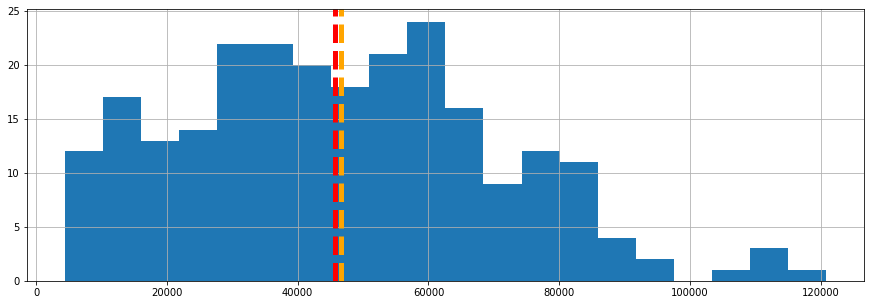

In [14]:
ax = serie_patentamientos.hist(bins=20, figsize=(15,5))

ax.axvline(serie_patentamientos.mean(), color='orange', linestyle='dashed', linewidth=5)
ax.axvline(serie_patentamientos.median(), color='red', linestyle='dashed', linewidth=5)

La media y la mediana son muy parecidas cuando la distribución se aproxima a la normal, pero se diferencian cuando una de las colas es sustancialmente más grande que la otra.

In [15]:
serie_patentamientos = df.groupby(
    ["anio_inscripcion_inicial", "mes_inscripcion_inicial", "provincia_id"]
).sum()[
    "cantidad_inscripciones_iniciales"]
serie_patentamientos

anio_inscripcion_inicial  mes_inscripcion_inicial  provincia_id
2000                      1                        2                8892
                                                   6               16346
                                                   10                361
                                                   14               4535
                                                   18                731
                                                                   ...  
2020                      2                        78                290
                                                   82               2503
                                                   86                261
                                                   90                792
                                                   94                256
Name: cantidad_inscripciones_iniciales, Length: 5808, dtype: int64

In [16]:
serie_patentamientos.agg(["mean", "median"])

mean      1942.35761
median     736.00000
Name: cantidad_inscripciones_iniciales, dtype: float64

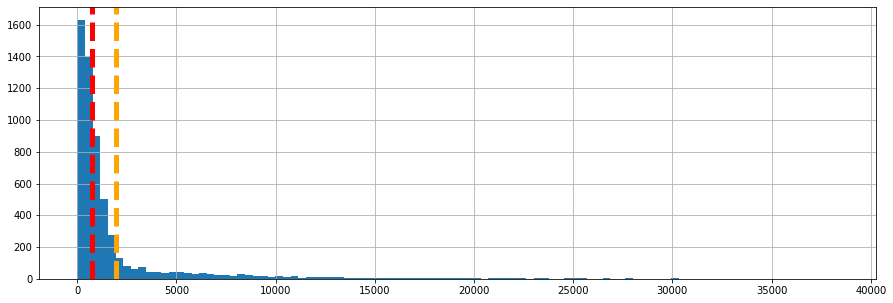

In [17]:
ax = serie_patentamientos.hist(bins=100, figsize=(15,5))

ax.axvline(serie_patentamientos.mean(), color='orange', linestyle='dashed', linewidth=5)
ax.axvline(serie_patentamientos.median(), color='red', linestyle='dashed', linewidth=5)

**Ejercicio:** calcular y graficar la media y la mediana de la cantidad de patentamientos por provincia en el año 2017. ¿Cuál es la provincia más cerca de la cantidad de patentamientos promedio y cuál de la cantidad de patentamientos mediana

## Desvío estándar, varianza y desviación absoluta

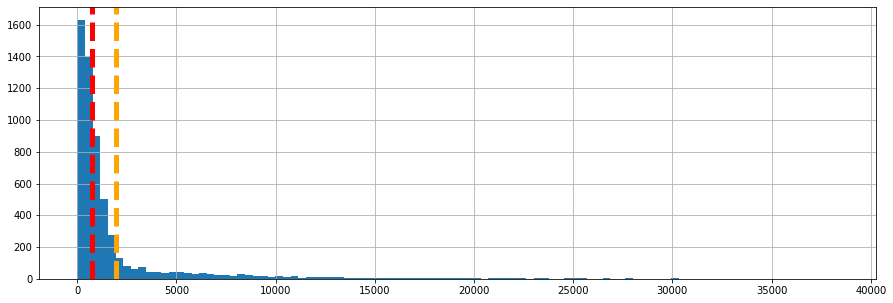

In [18]:
ax = serie_patentamientos.hist(bins=100, figsize=(15,5))

ax.axvline(serie_patentamientos.mean(), color='orange', linestyle='dashed', linewidth=5)
ax.axvline(serie_patentamientos.median(), color='red', linestyle='dashed', linewidth=5)

Desvío estándar

In [19]:
serie_patentamientos.std()

3753.5672422227863

Varianza

In [20]:
serie_patentamientos.var()

14089267.041887974

In [21]:
serie_patentamientos.std() ** 2

14089267.041887973

Desvío absoluto mediano

In [22]:
serie_patentamientos.mad()

2066.9925427024737

**Ejercicio:** Calcular el desvío estándar, la varianza y el desvío absoluto mediano de los patentamientos de automotores y motos por separado. ¿Cuál de ellos es más disperso? 

## Distribuciones probabilísticas 

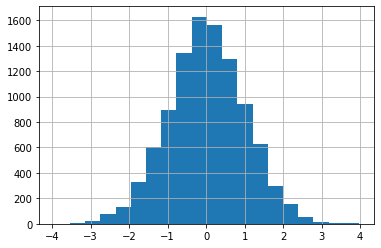

In [23]:
normal_distribution = pd.Series(np.random.normal(0, 1, 10000))
normal_distribution.hist(bins=20)

In [24]:
normal_distribution.mean()

0.015990861497839178

In [25]:
normal_distribution.median()

0.008703397239670348

In [26]:
normal_distribution.std()

0.989030091136738

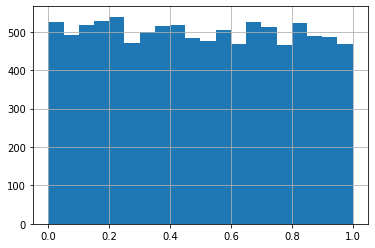

In [27]:
uniform_distribution = pd.Series(np.random.uniform(0, 1, 10000))
uniform_distribution.hist(bins=20)

In [28]:
uniform_distribution.mean()

0.49439842958478664

In [29]:
uniform_distribution.median()

0.4902722650903922

In [30]:
uniform_distribution.std()

0.28844319377965855

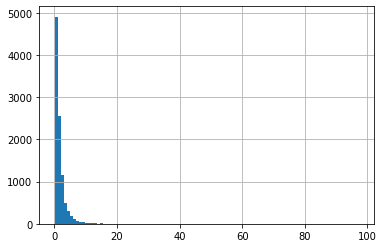

In [31]:
uniform_distribution = pd.Series(np.random.lognormal(0, 1, 10000))
uniform_distribution.hist(bins=100)

**Ejercicio:** graficar las tres distribuciones con su media y su mediana.

## Quantiles 

In [32]:
serie_patentamientos.quantile(0.5), serie_patentamientos.median()

(736.0, 736.0)

In [33]:
serie_patentamientos.quantile(0.25)

352.0

In [34]:
serie_patentamientos.quantile(0.75)

1472.0

**Ejercicio:** calcular valores maximo y minimo de la serie de patentamientos usando cuantiles y usando max() / min() y comparar el resultado.

**Ejercicio:** graficar la distribución y la distribución logarítmica con sus medianas y quantiles 0.25 y 0.75

## Valores anómalos (outliers)

Criterio 1: umbral de desvíos estándares.

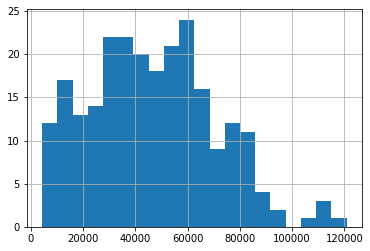

In [35]:
serie_patentamientos_normal = df.groupby(
    ["anio_inscripcion_inicial", "mes_inscripcion_inicial"]
).sum()[
    "cantidad_inscripciones_iniciales"]
serie_patentamientos_normal.hist(bins=20)

In [36]:
media = serie_patentamientos_normal.mean()
desvio_estandar = serie_patentamientos_normal.std()

umbral_superior = media + 3 * desvio_estandar
umbral_inferior = media - 3 * desvio_estandar

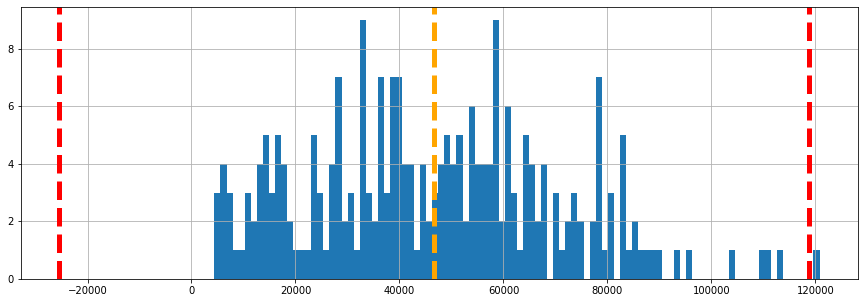

In [37]:
ax = serie_patentamientos_normal.hist(bins=100, figsize=(15,5))

ax.axvline(media, color='orange', linestyle='dashed', linewidth=5)
ax.axvline(umbral_inferior, color='red', linestyle='dashed', linewidth=5)
ax.axvline(umbral_superior, color='red', linestyle='dashed', linewidth=5)

In [38]:
serie_patentamientos_normal[serie_patentamientos_normal < umbral_inferior]

Series([], Name: cantidad_inscripciones_iniciales, dtype: int64)

In [39]:
serie_patentamientos_normal[serie_patentamientos_normal > umbral_superior]

anio_inscripcion_inicial  mes_inscripcion_inicial
2018                      1                          120788
Name: cantidad_inscripciones_iniciales, dtype: int64

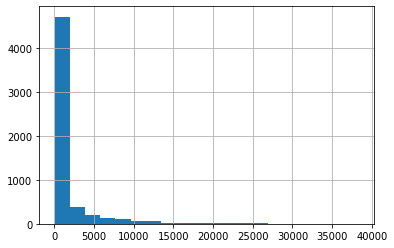

In [40]:
serie_patentamientos.hist(bins=20)

In [41]:
media = serie_patentamientos.mean()
desvio_estandar = serie_patentamientos.std()

umbral_superior = media + 3 * desvio_estandar
umbral_inferior = media - 3 * desvio_estandar

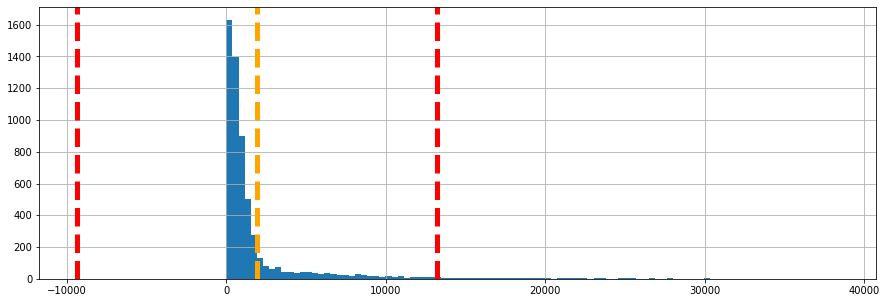

In [42]:
ax = serie_patentamientos.hist(bins=100, figsize=(15,5))

ax.axvline(media, color='orange', linestyle='dashed', linewidth=5)
ax.axvline(umbral_inferior, color='red', linestyle='dashed', linewidth=5)
ax.axvline(umbral_superior, color='red', linestyle='dashed', linewidth=5)

In [43]:
serie_patentamientos[serie_patentamientos < umbral_inferior]

Series([], Name: cantidad_inscripciones_iniciales, dtype: int64)

In [44]:
serie_patentamientos[serie_patentamientos > umbral_superior]

anio_inscripcion_inicial  mes_inscripcion_inicial  provincia_id
2000                      1                        6               16346
2005                      1                        6               15286
2006                      1                        6               18792
2007                      1                        2               15030
                                                   6               24854
                                                                   ...  
2018                      8                        6               19488
                          9                        6               15392
                          10                       6               14103
2019                      1                        6               18450
                          7                        6               14799
Name: cantidad_inscripciones_iniciales, Length: 149, dtype: int64

In [45]:
len(serie_patentamientos)

5808

**Ejercicio:** buscar los valores anómalos de patentamientos sólo de motos. ¿En qué mes y provincia son? ¿Se les ocurre alguna explicación?